In [1]:
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import interact

from ipywidgets import widgets
from tqdm.auto import tqdm

from vol.vol import Heston

from hestonmc import MarketState, HestonParameters, mc_price, simulate_heston_euler, simulate_heston_andersen_qe, simulate_heston_andersen_tg, european_call_payoff
from hestonmc_cuda import mc_price_cupy, simulate_heston_euler_cupy, simulate_heston_andersen_qe_cupy, simulate_heston_andersen_tg_cupy, european_call_payoff_cupy

## Tests

In [56]:
#heston_params = HestonParameters(kappa = 1.3125, gamma = 0.5125, rho = -0.3937, vbar = 0.0641, v0 = 0.3) #from stoch vol
#heston_params = HestonParameters(kappa = 1, gamma = 0.4, rho = -0.1, vbar = 0.2, v0 = 0.2) # from school
heston_params = HestonParameters(kappa = 0.5, gamma = 1, rho = -0.9, vbar = 0.04, v0 = 0.04) #  from andeson paper 1
#heston_params = HestonParameters(kappa = 0.3, gamma = 0.9, rho = -0.5, vbar = 0.04, v0 = 0.04) #  from andeson paper 2
#heston_params = HestonParameters(kappa = 1, gamma = 1, rho = -0.3, vbar = 0.04, v0 = 0.09) #  from andeson paper 3
 
state         = MarketState(stock_price = 1.*100, interest_rate = 0.)
model         = Heston(state.stock_price, heston_params.v0, heston_params.kappa, heston_params.vbar, heston_params.gamma, heston_params.rho, state.interest_rate)

r_x           = np.load(r"Data/anderson tg/r_x start=1e-07 stop=100 N=4999998 dt=2e-05.npy")
f_nu_y        = np.load(r"Data/anderson tg/f_nu_y start=1e-07 stop=100 N=4999998 dt=2e-05.npy")
f_sigma_y     = np.load(r"Data/anderson tg/f_sigma_y start=1e-07 stop=100 N=4999998 dt=2e-05.npy")
kwargs        = {'x_grid' : r_x, 'f_nu_grid' : f_nu_y, 'f_sigma_grid' : f_sigma_y }
r_x           = cp.load(r"Data/anderson tg/r_x start=1e-07 stop=100 N=4999998 dt=2e-05.npy")
f_nu_y        = cp.load(r"Data/anderson tg/f_nu_y start=1e-07 stop=100 N=4999998 dt=2e-05.npy")
f_sigma_y     = cp.load(r"Data/anderson tg/f_sigma_y start=1e-07 stop=100 N=4999998 dt=2e-05.npy")
kwargs_cupy        = {'x_grid' : r_x, 'f_nu_grid' : f_nu_y, 'f_sigma_grid' : f_sigma_y }

In [3]:
#measure of bound of psi for tg model

heston_params.gamma**2/(2*heston_params.kappa*heston_params.vbar)

33.75

### At the money

In [82]:
strike = 70.
T = 10
ec_payoff = european_call_payoff_cupy(T, strike, state.interest_rate)
1
common_mc_params = {"absolute_error": 0.99, "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "verbose": True}

In [85]:
strike = 70.
T = 10
ec_payoff = european_call_payoff(T, strike, state.interest_rate)
1
common_mc_params = {"absolute_error": 0.99, "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "verbose": True}

In [86]:
model.call_price(T, strike)

35.849769703753964

In [95]:
mc_price(N_T = 40, simulate = simulate_heston_euler,batch_size=500_000, **common_mc_params) - model.call_price(T, strike)

Number of simulate calls:   1
MAX_ITER:                   100000
Number of paths:            1000000
Absolute error:             0.99
Length of the conf intl:    0.10121469145901638
Confidence level:           0.05



1.0828000658573416

In [16]:
mc_price_cupy(N_T = 60, simulate = simulate_heston_euler_cupy,batch_size=500_000, **common_mc_params)

Number of simulate calls:   1
MAX_ITER:                   100000
Number of paths:            1000000
Absolute error:             0.99
Length of the conf intl:    0.253156261820319
Confidence level:           0.05



array(18.884078)

In [94]:
mc_price(N_T = 40, simulate = simulate_heston_andersen_qe, batch_size=500_000, **common_mc_params) - model.call_price(T, strike)

Number of simulate calls:   1
MAX_ITER:                   100000
Number of paths:            1000000
Absolute error:             0.99
Length of the conf intl:    0.0874130483908439
Confidence level:           0.05



0.1992318600557681

In [77]:
mc_price_cupy(N_T = 60, simulate = simulate_heston_andersen_qe_cupy, batch_size=500_000, **common_mc_params)

Number of simulate calls:   1
MAX_ITER:                   100000
Number of paths:            1000000
Absolute error:             0.99
Length of the conf intl:    0.051543620893657674
Confidence level:           0.05



/media/kir1200/E4C4BDFBC4BDCFD2/Other/code/jypeter/Stochastic-Volatility-Models/Code/hestonmc.py:24: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "payoff" failed type inference due to: non-precise type pyobject
During: typing of argument at /media/kir1200/E4C4BDFBC4BDCFD2/Other/code/jypeter/Stochastic-Volatility-Models/Code/hestonmc.py (26)

File "hestonmc.py", line 26:
    def payoff(St: np.ndarray):
        DF = np.exp( - interest_rate * maturity)
        ^

  @jit
/home/kir1200/anaconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "payoff" was compiled in object mode without forceobj=True.

File "hestonmc.py", line 25:
    @jit
    def payoff(St: np.ndarray):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/kir1200/anaconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object m

array(13.120816)

In [97]:
mc_price(N_T = 40, simulate = simulate_heston_andersen_tg, batch_size=500_000, **common_mc_params, **kwargs) - model.call_price(T, strike)

Number of simulate calls:   1
MAX_ITER:                   100000
Number of paths:            1000000
Absolute error:             0.99
Length of the conf intl:    0.08716469708339186
Confidence level:           0.05



0.5707650206403443

In [67]:
mc_price_cupy(N_T = 100, simulate = simulate_heston_andersen_tg_cupy, batch_size=200_000, **common_mc_params, **kwargs_cupy)

Number of simulate calls:   29
MAX_ITER:                   100000
Number of paths:            11600000
Absolute error:             0.05
Length of the conf intl:    0.049498563778828227
Confidence level:           0.05



array(22.38157793)

In [41]:
%timeit mc_price(N_T = 100, simulate = simulate_heston_andersen_tg_cupy, batch_size=200_000, **common_mc_params, **kwargs_cupy)

788 ms ± 5.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Optimal batch_size for each scheme

In [45]:
common_mc_params = {"absolute_error": 5e-2,  "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}
for scheme in [[simulate_heston_euler_cupy, 100], [simulate_heston_andersen_qe_cupy, 100], [simulate_heston_andersen_tg_cupy, 100]]:
    print(scheme[0].__name__)
    for batch_size in range(100_000, 1000_000, 50_000):
        print(f"Batch size: {batch_size}")
        if scheme[0] == simulate_heston_andersen_tg_cupy:
            %timeit -r7 mc_price(N_T = scheme[1], simulate = scheme[0], batch_size=batch_size, **common_mc_params, **kwargs_cupy)
        else:
            %timeit -r7 mc_price(N_T = scheme[1], simulate = scheme[0], batch_size=batch_size, **common_mc_params)

    print("\n\n")

simulate_heston_euler_cupy
Batch size: 100000
592 ms ± 5.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 150000
582 ms ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 200000
578 ms ± 8.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 250000
570 ms ± 6.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 300000
560 ms ± 4.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 350000
592 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 400000
582 ms ± 9.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 450000
563 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 500000
631 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 550000
575 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 600000
622 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch size: 6500

In [6]:
import pandas as pd

In [19]:
MC_compare_models = pd.DataFrame(columns=['scheme' , 'N_dt',  'result'])

In [20]:
common_mc_params = {"absolute_error": 5e-2,  "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}
i = 0
for scheme in [simulate_heston_euler_cupy, simulate_heston_andersen_qe_, simulate_heston_andersen_tg]:
    for N_dt in range(4, 132, 4):
        for _ in range(150):
            if scheme == simulate_heston_andersen_tg:
                MC_compare_models.loc[i] = (scheme.__name__, N_dt, mc_price(N_T = N_dt, simulate = scheme, batch_size=5000, **common_mc_params, **kwargs))
            else:
                MC_compare_models.loc[i] = (scheme.__name__, N_dt, mc_price(N_T = N_dt, simulate = scheme, batch_size=5000, **common_mc_params))
            i +=1

In [41]:
MC_compare_models = pd.read_csv(r"Data/evaluation/MC_compare_models.csv")

In [56]:
tmp = MC_compare_models.groupby(['scheme', 'N_dt'] ).agg([np.mean, np.std])['result']

<AxesSubplot:title={'center':'MC_compare_models'}, xlabel='scheme,N_dt'>

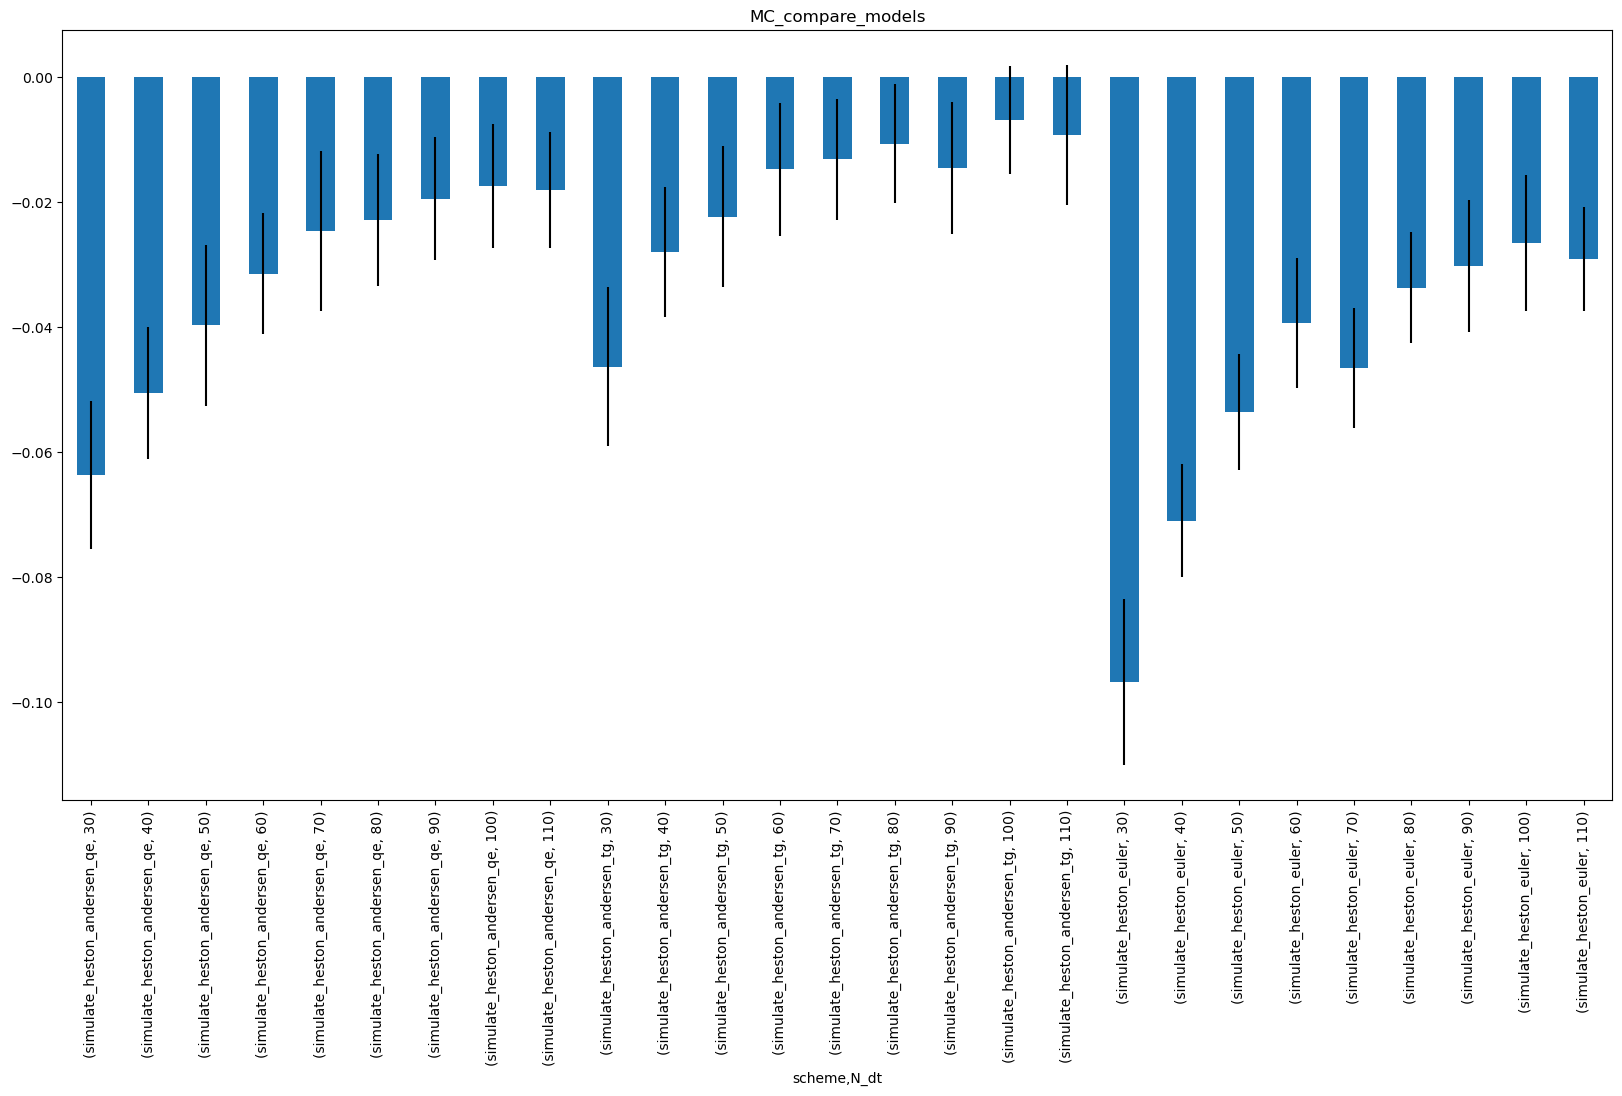

In [57]:
tmp['mean'] = tmp['mean'] - model.call_price(T, strike)
tmp['mean'].plot(kind='bar', yerr=tmp['std'], figsize=(20,10), title='MC_compare_models')

In [21]:
MC_compare_models.to_csv('MC_compare_models.csv')

In [113]:
MC_compare_models_grid = pd.DataFrame(columns=['scheme' , 'strike', 'T', 'true' ])

In [115]:

i = 0
for scheme in [simulate_heston_euler, simulate_heston_andersen_qe, simulate_heston_andersen_tg]:
    for strike in np.linspace(80, 120, 10):
        for T in np.linspace(0.1, 1, 10):
            T = float(T/10)
            res = []
            ec_payoff = european_call_payoff(T, strike, state.interest_rate)
            common_mc_params = {"absolute_error": 5e-2, "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}

            if scheme == simulate_heston_andersen_tg:
                res.append(mc_price(N_T = 50, simulate = scheme, batch_size=5000, **common_mc_params, **kwargs))
            elif scheme == simulate_heston_euler:
                res.append(mc_price(N_T = 100, simulate = scheme, batch_size=5000, **common_mc_params))
            elif scheme == simulate_heston_andersen_qe:
                res.append(mc_price(N_T = 50, simulate = scheme, batch_size=5000, **common_mc_params))
            MC_compare_models_grid.loc[i] = (scheme.__name__, strike, T, model.call_price(T, strike), np.mean(res), np.std(res))
            i +=1

In [141]:
MC_compare_models_grid.to_csv('MC_compare_models_grid.csv')

In [7]:
MC_compare_models_grid = pd.read_csv('MC_compare_models_grid.csv')

In [25]:
MC_compare_models_grid[MC_compare_models_grid['scheme'] == 'simulate_heston_euler'][['strike', 'T', 'mean']].pivot(index='strike', columns='T', values='mean')

T,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
strike,,,,,,,,,,
85,16.468112,18.174956,19.532771,20.625552,21.550519,22.332203,22.995971,23.566372,24.089111,24.545769
90,12.650948,14.723351,16.272476,17.479529,18.475317,19.311487,20.019792,20.630731,21.182393,21.658118
95,9.355494,11.713190,13.389183,14.677016,15.724589,16.607905,17.325401,17.982222,18.551199,19.052880
100,6.667335,9.134282,10.859212,12.190673,13.268413,14.169324,14.929257,15.581933,16.165246,16.673012
105,4.549369,7.001336,8.725293,10.045786,11.132874,12.023971,12.775523,13.443150,14.031471,14.530141
110,2.992315,5.262253,6.916464,8.198667,9.267407,10.141301,10.895954,11.536549,12.127461,12.630638
115,1.907261,3.882004,5.407551,6.649103,7.644796,8.509682,9.244054,9.884885,10.454079,10.939673


In [27]:
#3d plot the results for the euler scheme
import plotly.graph_objects as go
import plotly.express as px

"""x= np.linspace(0.1, 1.1, 0.1)
y= np.linspace(85, 120, 5)"""
fig = go.Figure(data=[go.Surface(z=MC_compare_models_grid[MC_compare_models_grid['scheme'] == 'simulate_heston_euler'][['strike', 'T', 'mean']].pivot(index='strike', columns='T', values='mean'))])
fig.show()

Time for each scheme

In [10]:
common_mc_params = {"absolute_error": 5e-2, "batch_size": 100_000, "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}
for scheme in [[simulate_heston_euler, 100], [simulate_heston_andersen_qe, 50], [simulate_heston_andersen_tg, 50]]:
    print(scheme[0].__name__)
    if scheme[0] == simulate_heston_andersen_tg:
        %timeit -r10 mc_price(N_T = scheme[1], simulate = scheme[0], **common_mc_params, **kwargs)
    else:
        %timeit -r10 mc_price(N_T = scheme[1], simulate = scheme[0], **common_mc_params)

    print("\n\n")

simulate_heston_euler
2.58 s ± 40.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)



simulate_heston_andersen_qe
1.61 s ± 19.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)



simulate_heston_andersen_tg
1.54 s ± 23.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)





### Out of the money

In [101]:
strike = 150.
T = 1.
ec_payoff = european_call_payoff(T, strike, state.interest_rate)

common_mc_params = {"absolute_error": 5e-2, "batch_size": 100_000, "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": True}

In [102]:
model.call_price(T, strike)

4.40338420430231

In [104]:
mc_price(N_T = 100, simulate = simulate_heston_euler, **common_mc_params)

Random seed:                42
Number of simulate calls:   1
MAX_ITER:                   100000
Number of paths:            200000
Absolute error:             0.05
Length of the conf intl:    0.03722537091824368
Confidence level:           0.05



4.532980906297427

In [105]:
mc_price(N_T = 50, simulate = simulate_heston_andersen_qe, **common_mc_params)

Random seed:                42
Number of simulate calls:   1
MAX_ITER:                   100000
Number of paths:            200000
Absolute error:             0.05
Length of the conf intl:    0.035479385422419435
Confidence level:           0.05



4.391502273180451

In [106]:
mc_price(N_T = 50, simulate = simulate_heston_andersen_tg, **common_mc_params, **kwargs)

Random seed:                42
Number of simulate calls:   1
MAX_ITER:                   100000
Number of paths:            200000
Absolute error:             0.05
Length of the conf intl:    0.03513980639277515
Confidence level:           0.05



4.411496646066571

In [27]:
import pandas as pd
MC_compare_models_Out_of_the_money = pd.DataFrame(columns=['scheme' , 'N_dt',  'result'])

In [28]:
common_mc_params = {"absolute_error": 5e-2,  "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}
i = MC_compare_models_Out_of_the_money.shape[0]
for scheme in [simulate_heston_euler, simulate_heston_andersen_qe, simulate_heston_andersen_tg]:
    for N_dt in range(4, 132, 4):
        for _ in range(5):
            if scheme == simulate_heston_andersen_tg:
                MC_compare_models_Out_of_the_money.loc[i] = (scheme.__name__, N_dt, mc_price(N_T = N_dt, simulate = scheme, batch_size=5000, **common_mc_params, **kwargs))
            else:
                MC_compare_models_Out_of_the_money.loc[i] = (scheme.__name__, N_dt, mc_price(N_T = N_dt, simulate = scheme, batch_size=5000, **common_mc_params))
            i +=1

SystemError: CPUDispatcher(<function simulate_heston_euler at 0x000001FF6AAFF550>) returned a result with an error set

Calculation of r for anderson tg model

In [4]:
from hestonmc import calculate_r_for_andersen_tg
from tqdm.notebook import tqdm

dt = 2e-05

h = int(np.array(np.arange(1e-7, 100, dt)).shape[0]/6)

i = 0

#r_x = np.linspace(1e-7, 100, 1000)

r_x = np.array(np.arange(1e-7, 100, dt))[i*h:(i+1)*h]

In [8]:

r_y = np.zeros(r_x.shape)

for j in tqdm(range(r_x.shape[0])):
    r_y[j] = calculate_r_for_andersen_tg(r_x[j], tol = 1e-7)

  0%|          | 0/833333 [00:00<?, ?it/s]

In [15]:
np.save("r_x {0} {1} {2}.npy".format(i*h*dt, (i+1)*h*dt, r_x.shape[0]), r_x)
np.save("r_y {0} {1} {2}.npy".format(i*h*dt, (i+1)*h*dt, r_x.shape[0]), r_y)

In [111]:
r_x_all = np.empty(0)
r_y_all = np.empty(0)

for j in range(0, 6):
    i = j
    r_x = np.load("r_x {0} {1} {2}.npy".format(i*h*dt, (i+1)*h*dt, h))
    print(r_x[0], r_x[-1])
    r_y = np.load("r_y {0} {1} {2}.npy".format(i*h*dt, (i+1)*h*dt, h))

    r_x_all = np.concatenate((r_x_all, r_x))
    r_y_all = np.concatenate((r_y_all, r_y))
    #plt.plot(r_x, r_y, label = "{0} to {1}".format(i*h*dt, (i+1)*h*dt))

1e-07 16.666640100000002
16.6666601 33.3333001
33.3333201 49.9999601
49.9999801 66.6666201
66.6666401 83.3332801
83.3333001 99.9999401


In [119]:
r_x_all[-1] + dt

99.99996010000001

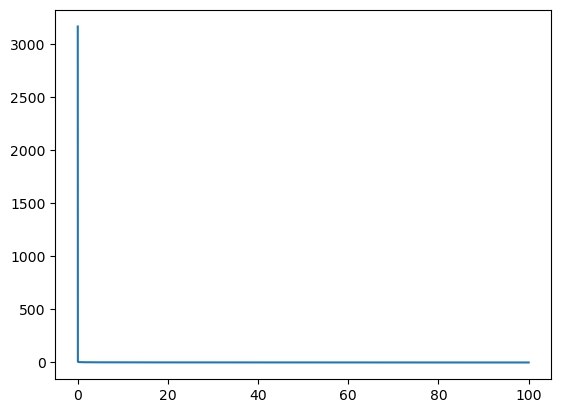

In [134]:
#plot r_x and r_y with plt
import matplotlib.pyplot as plt
plt.plot(r_x_all, r_y_all)
plt.show()


In [115]:
dt

2e-05

In [117]:
np.save("r_x start={0} stop={1} N={2} dt={3}.npy".format(1e-7, 100, r_x_all.shape[0], dt), r_x_all)
np.save("r_y start={0} stop={1} N={2} dt={3}.npy".format(1e-7, 100, r_x_all.shape[0], dt), r_y_all)

In [120]:
from scipy.stats import norm

f_nu_y = r_y_all/(norm.pdf(r_y_all) + r_y_all*norm.cdf(r_y_all))
f_sigma_y = 1/((norm.pdf(r_y_all) + r_y_all*norm.cdf(r_y_all))*np.sqrt(r_x_all))

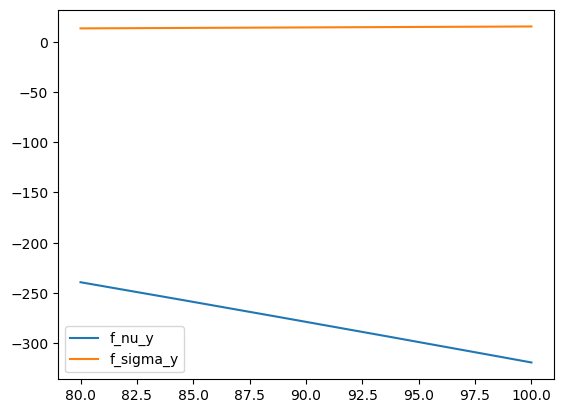

In [136]:
#plot f_nu_y and f_sigma_y
plt.plot(r_x_all[-1000000:], f_nu_y[-1000000:], label = "f_nu_y")
plt.plot(r_x_all[-1000000:], f_sigma_y[-1000000:], label = "f_sigma_y")
plt.legend()
plt.show()


In [122]:
np.save("f_nu_y start={0} stop={1} N={2} dt={3}.npy".format(1e-7, 100, r_x_all.shape[0], dt), f_nu_y)
np.save("f_sigma_y start={0} stop={1} N={2} dt={3}.npy".format(1e-7, 100, r_x_all.shape[0], dt), f_sigma_y)